In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
epochs = 20
batch_size = 16
margin = 1  # Margin for constrastive loss.

In [4]:
from pickle import load

x_path = r'/content/drive/MyDrive/face_detection_files/siamese_model/data_X.pkl'
y_path = r'/content/drive/MyDrive/face_detection_files/siamese_model/data_y.pkl'

with open(x_path, 'rb') as f:
  x_train_val = load(f)

with open(y_path, 'rb') as f:
  y_train_val = load(f)


print(x_train_val.shape)
print(y_train_val.shape)


(4004, 100, 100)
(4004,)


In [5]:
from sklearn.utils import shuffle

x_train_val, y_train_val = shuffle(x_train_val, y_train_val)

2


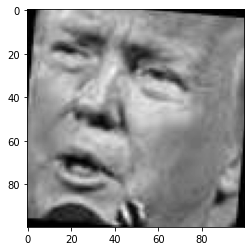

In [6]:
# barack_obama: 0
# bill_gates: 1
# donald_trump: 2
# queen_elizabeth: 3

from matplotlib.pyplot import imshow

print(y_train_val[100])
imshow(x_train_val[100], cmap = 'gray')

In [7]:
x_test = x_train_val[:500]
y_test = y_train_val[:500]
x_train, x_val = x_train_val[500:1752], x_train_val[1752:]
y_train, y_val = y_train_val[500:1752], y_train_val[1752:]

del x_train_val, y_train_val

In [16]:
max(y_test)

3

In [8]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [9]:
pairs_train.shape

(2504, 2, 100, 100)

In [10]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]


x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]


x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

In [11]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

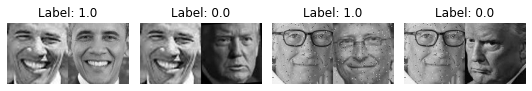

In [12]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

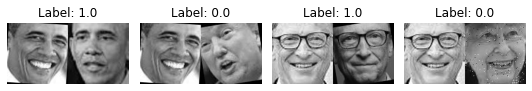

In [13]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

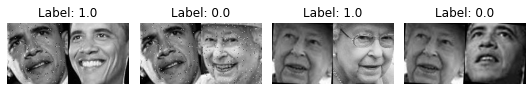

In [14]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

In [18]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((100, 100, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(8, (10, 10), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(5, 5))(x)
x = layers.Conv2D(64, (10, 10), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(5, 5))(x)
x = layers.Conv2D(128, (10, 10), activation="tanh", padding="same")(x)
x = layers.AveragePooling2D(pool_size=(2, 2), padding="same")(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(20, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((100, 100, 1))
input_2 = layers.Input((100, 100, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


In [19]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [20]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 20)           874496      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

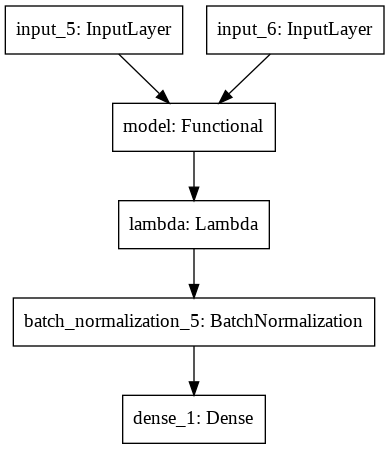

In [21]:
from keras.utils.vis_utils import plot_model

plot_model(siamese)

In [22]:
history = siamese.fit([x_train_1, x_train_2], labels_train, validation_data=([x_val_1, x_val_2], labels_val), batch_size=batch_size,epochs=epochs)

Epoch 1/20
157/157 [==============================] - 8s 30ms/step - loss: 0.2796 - accuracy: 0.5543 - val_loss: 0.2887 - val_accuracy: 0.5442
Epoch 2/20
157/157 [==============================] - 4s 27ms/step - loss: 0.2684 - accuracy: 0.5471 - val_loss: 0.2525 - val_accuracy: 0.5480
Epoch 3/20
157/157 [==============================] - 4s 27ms/step - loss: 0.2452 - accuracy: 0.5787 - val_loss: 0.2329 - val_accuracy: 0.5999
Epoch 4/20
157/157 [==============================] - 4s 27ms/step - loss: 0.2190 - accuracy: 0.6398 - val_loss: 0.2154 - val_accuracy: 0.6370
Epoch 5/20
157/157 [==============================] - 4s 27ms/step - loss: 0.1814 - accuracy: 0.7524 - val_loss: 0.1642 - val_accuracy: 0.7833
Epoch 6/20
157/157 [==============================] - 4s 27ms/step - loss: 0.1389 - accuracy: 0.8395 - val_loss: 0.1602 - val_accuracy: 0.7833
Epoch 7/20
157/157 [==============================] - 4s 27ms/step - loss: 0.0947 - accuracy: 0.9149 - val_loss: 0.0906 - val_accuracy: 0.8934

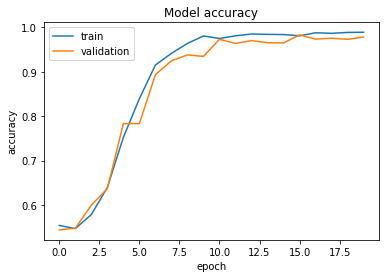

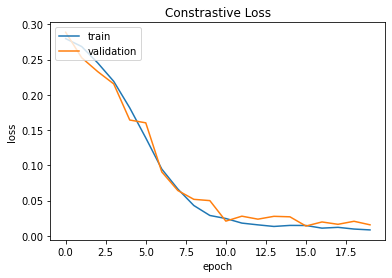

In [23]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [24]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

32/32 [==============================] - 0s 10ms/step - loss: 0.0113 - accuracy: 0.9840
test loss, test acc: [0.011294837109744549, 0.984000027179718]


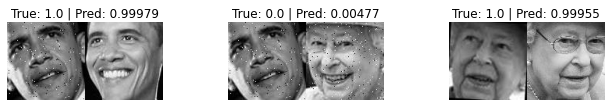

In [25]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)

In [26]:
siamese.save(r'/content/drive/MyDrive/face_detection_files/siamese_model/siamese_model.h5')